# PySpark

## Spark Environment

### Cơ chế hoạt động của spark

Bước đầu tiên để thiết lập spark là tạo ra 1 cụm xử lý (`cluster`) trên một máy chủ. Cụm xử lý này được kết nối tới rất nhiều nodes khác nhau. Máy chủ (`master`) sẽ làm nhiệm vụ: phân chia dữ liệu và quản lý tính toán trên các máy con. máy chủ sẽ kết nối đến các máy con (`slaves`) trong cụm bằng các `session`. Máy chủ sẽ gửi dữ liệu và yêu cầu tính toán để máy con thực thi. Sau khi có kết quả máy con có nhiệm vụ trả về máy chủ. Máy chủ tổng hợp tất cả các tính toán trên máy con để tính ra kết quả cuối cùng.

Trong bài này do mới làm quen với spark nên mình sẽ khởi tạo một cluster trên local. Thay vì kết nối tới những máy khác, các tính toán sẽ được thực hiện chỉ trên server local thông qua một giả lập cụm.

Để kiểm tra các schema có trong một table chúng ta sử dụng hàm `printSchema()`

### Tìm kiếm spark environment

In [14]:
# find the env spark
import findspark
findspark.init()

import pyspark

 # khởi tạo trình chạy pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Lesson1').getOrCreate()
spark 

In [2]:
# check cores
spark._jsc.sc().getExecutorMemoryStatus().keySet().size()

1

## DataFrame Creation

### Import dataframe to catelog

Tuy nhiên lúc này **flights** vẫn chỉ là một spark DataFrame chưa có trong **catalog** của của **cluster**. Sử dụng hàm `listTable()` liệt kê danh sách bảng ta thu được 1 list rỗng.

Lý do là bởi khi được đọc từ hàm `read.csv()` thì dữ liệu chỉ được lưu trữ ở Local dưới dạng một spark DataFrame. Để đưa dự liệu từ local lên cluster chúng ta cần save nó dưới dạng một **temporary table** thông một trong những lệnh bên dưới:
- `.createTempView()`: là một phương thức của spark DataFrame trong đó tham số duy nhất được truyền vào là tên bảng mà bạn muốn lưu trữ dưới dạng temporary table. Bảng được tạo ra là tạm thời và chỉ có thể được truy cập từ session được sử dụng để tạo ra spark DataFrame.
- `.createOrReplaceTempView()`: Có tác dụng hoàn toàn giống như .createTempView() nhưng nó sẽ update lại temporary table nếu nó đã tồn tại hoặc tạo mới nếu chưa tồn tại trước dây. Tránh trường hợp duplicate dữ liệu.
- `.createDataFrame()`: Tạo một spark DataFrame từ một pandas DataFrame.

Để hiểu rõ hơn về nguyên tắc khởi tạo bảng chúng ta có thể xem sơ đồ bên dưới:

![](https://s3.amazonaws.com/assets.datacamp.com/production/course_4452/datasets/spark_figure.png)

**Spark Cluster** sẽ tương tác với **user** thông qua kết nối từ **SparkContext**. Có 2 dạng lưu trữ chính ở **SparkContext** là spark **DataFrame** và **catalog**. Trong đó **spark DataFrame** là định dạng dạng bảng được lưu trữ ở Local và **catalog** là các temporary table sống trong các **SparkSession**. Để dữ liệu có thể truy cập từ một session chúng ta cần chuyển nó từ định dạng **spark DataFrame** sang **temporary table** thông qua hàm `.createTempView()` hoặc `.createOrReplaceTempView()`.

Bên dưới ta sẽ khởi tạo một **temporary table** với tên là `flights_temp` cho bảng **flights**.

In [ ]:
# Create a temporary table on catalog of local data frame flights as new temporary table flights_temp on catalog
flights.createOrReplaceTempView('flights_temp')
# check list all table available on catalog
my_spark.catalog.listTables()

[Table(name='flights_temp', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

### Create dataframe

In [13]:
# create from row
from datetime import datetime, date
import pandas as pd
from pyspark.sql import Row

df = spark.createDataFrame([
    Row(a=1, b=2., c='string1', d=date(2000, 1, 1), e=datetime(2000, 1, 1, 12, 0)),
    Row(a=2, b=3., c='string2', d=date(2000, 2, 1), e=datetime(2000, 1, 2, 12, 0)),
    Row(a=4, b=5., c='string3', d=date(2000, 3, 1), e=datetime(2000, 1, 3, 12, 0))
])
df.show()

+---+---+-------+----------+-------------------+
|  a|  b|      c|         d|                  e|
+---+---+-------+----------+-------------------+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|
|  2|3.0|string2|2000-02-01|2000-01-02 12:00:00|
|  4|5.0|string3|2000-03-01|2000-01-03 12:00:00|
+---+---+-------+----------+-------------------+



In [7]:
# create from tuple
df = spark.createDataFrame([
    (1, 2., 'string1', date(2000, 1, 1), datetime(2000, 1, 1, 12, 0)),
    (2, 3., 'string2', date(2000, 2, 1), datetime(2000, 1, 2, 12, 0)),
    (3, 4., 'string3', date(2000, 3, 1), datetime(2000, 1, 3, 12, 0))
], schema='a long, b double, c string, d date, e timestamp')
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

In [8]:
# Create a PySpark DataFrame from an RDD consisting of a list of tuples.
rdd = spark.sparkContext.parallelize([
    (1, 2., 'string1', date(2000, 1, 1), datetime(2000, 1, 1, 12, 0)),
    (2, 3., 'string2', date(2000, 2, 1), datetime(2000, 1, 2, 12, 0)),
    (3, 4., 'string3', date(2000, 3, 1), datetime(2000, 1, 3, 12, 0))
])
df = spark.createDataFrame(rdd, schema=['a', 'b', 'c', 'd', 'e'])
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

In [23]:
# from pandas.dataframe
pandas_df = pd.DataFrame({
    'a': [1, 2, 3],
    'b': [2., 3., 4.],
    'c': ['string1', 'string2', 'string3'],
    'd': [date(2000, 1, 1), date(2000, 2, 1), date(2000, 3, 1)],
    'e': [datetime(2000, 1, 1, 12, 0), datetime(2000, 1, 2, 12, 0), datetime(2000, 1, 3, 12, 0)]
})
df = spark.createDataFrame(pandas_df)
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

### Reading file

In [3]:
import os
file = os.path.normpath(os.path.join(os.getcwd(),"..","0. Data",'datatest.csv')) ## ".." to get out folder
file

'J:\\My Drive\\GitCode\\My_learning\\11. BigData\\0. Data\\datatest.csv'

In [4]:
df = spark.read.csv(file,header=True)
df.show(1)

+---+------------+-----------+------------+-----------+-------+
|_c0|sepal_length|sepal_width|petal_length|petal_width|species|
+---+------------+-----------+------------+-----------+-------+
|  0|         5.1|        3.5|         1.4|        0.2| setosa|
+---+------------+-----------+------------+-----------+-------+
only showing top 1 row



In [23]:
# csv
import os
# file = os.path.normpath(os.path.join(os.getcwd(),"..","2.Dask",'datatest','1989.csv')) ## ".." to get out folder
df = spark.read.csv(r"J:\My Drive\GitCode\My_learning\11. BigData\0. Data\datatest.csv",header=True)
df.show(1)

+---+------------+-----------+------------+-----------+-------+
|_c0|sepal_length|sepal_width|petal_length|petal_width|species|
+---+------------+-----------+------------+-----------+-------+
|  0|         5.1|        3.5|         1.4|        0.2| setosa|
+---+------------+-----------+------------+-----------+-------+
only showing top 1 row



In [19]:
import myfunction as mf
mf.display(df.limit(4).toPandas())

,_c0,sepal_length,sepal_width,petal_length,petal_width,species
0,0,5.1,3.5,1.4,0.2,setosa
1,1,4.9,3.0,1.4,0.2,setosa
2,2,4.7,3.2,1.3,0.2,setosa
3,3,4.6,3.1,1.5,0.2,setosa


In [ ]:
# read parquet
df = spark.read.parquet('data.parquet') # read file parquet

# read many file parquet with the sample form
df_all = spark.read.parquet('data*.parquet')
df1_2 = spark.read.parquet('data1.parquet','data2.parquet')
df = spark.read.option('bathPath',path).parquet(path + '//data*.parquet') # set option
df = spark.read.parquet(folder1 +"//data*.parquet", folder2 +"//*") # set option

## Dataframe function

### Viewing

In [ ]:
df.limit(3).show()

+---+------------+-----------+------------+-----------+-------+
|_c0|sepal_length|sepal_width|petal_length|petal_width|species|
+---+------------+-----------+------------+-----------+-------+
|  0|         5.1|        3.5|         1.4|        0.2| setosa|
|  1|         4.9|        3.0|         1.4|        0.2| setosa|
|  2|         4.7|        3.2|         1.3|        0.2| setosa|
+---+------------+-----------+------------+-----------+-------+



In [ ]:
# show sample
df.show(1)

+---+---+-------+----------+-------------------+
|  a|  b|      c|         d|                  e|
+---+---+-------+----------+-------------------+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|
+---+---+-------+----------+-------------------+
only showing top 1 row



In [ ]:
df.show(1, vertical=True)

-RECORD 0------------------
 a   | 1                   
 b   | 2.0                 
 c   | string1             
 d   | 2000-01-01          
 e   | 2000-01-01 12:00:00 
only showing top 1 row



In [ ]:
# len df 
df.count()

3

In [ ]:
spark.sql.repl.eagerEval.maxNumRows # setup maxrow to show
spark.conf.set('spark.sql.repl.eagerEval.enabled', True) # setup config to show in jupyter
df

a,b,c,d,e
1,2.0,string1,2000-01-01,2000-01-01 12:00:00
2,3.0,string2,2000-02-01,2000-01-02 12:00:00
3,4.0,string3,2000-03-01,2000-01-03 12:00:00


In [ ]:
# dtype
df.printSchema()

root
 |-- a: long (nullable = true)
 |-- b: double (nullable = true)
 |-- c: string (nullable = true)
 |-- d: date (nullable = true)
 |-- e: timestamp (nullable = true)



In [ ]:
# convert pandas.df
df.toPandas()

,a,b,c,d,e
0,1,2.0,string1,2000-01-01,2000-01-01 12:00:00
1,2,3.0,string2,2000-02-01,2000-01-02 12:00:00
2,3,4.0,string3,2000-03-01,2000-01-03 12:00:00


In [ ]:
# show columns
df.columns

['a', 'b', 'c', 'd', 'e']

### Validate datatype

In [ ]:
df.printSchema() # get dtype by SAMPLE of beginning datafile

root
 |-- _c0: string (nullable = true)
 |-- sepal_length: string (nullable = true)
 |-- sepal_width: string (nullable = true)
 |-- petal_length: string (nullable = true)
 |-- petal_width: string (nullable = true)
 |-- species: string (nullable = true)



In [ ]:
df.describe()

DataFrame[summary: string, _c0: string, sepal_length: string, sepal_width: string, petal_length: string, petal_width: string, species: string]

In [ ]:
df.schema['sepal_length']

StructField('sepal_length', StringType(), True)

In [ ]:
from pyspark.sql.types import *

# set schema
data_schema = [
            # StructField('_c0',IntegerType()),
              StructField('sepal_length',FloatType()),
              StructField('sepal_width',FloatType()),
              # StructField('petal_length',FloatType()), # dont need to set all
              StructField('petal_width',FloatType()),
              StructField('species',StringType()),
              ]

final_struc = StructType(fields = data_schema)

df = spark.read.csv(file,header=True,schema = final_struc)

df.printSchema() # chỉ đọc những cột có định nghĩa trong final_struc schema

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- species: string (nullable = true)



In [ ]:
df.show(2)
df.printSchema()

+---+------------+-----------+------------+-----------+-------+
|_c0|sepal_length|sepal_width|petal_length|petal_width|species|
+---+------------+-----------+------------+-----------+-------+
|  0|         5.1|        3.5|         1.4|        0.2| setosa|
|  1|         4.9|        3.0|         1.4|        0.2| setosa|
+---+------------+-----------+------------+-----------+-------+
only showing top 2 rows

root
 |-- _c0: string (nullable = true)
 |-- sepal_length: string (nullable = true)
 |-- sepal_width: string (nullable = true)
 |-- petal_length: string (nullable = true)
 |-- petal_width: string (nullable = true)
 |-- species: string (nullable = true)



In [ ]:
# change the dtype columns
from pyspark.sql.types import *

df = df.withColumn('sepal_length',df['sepal_length'].cast(FloatType()) )\
        .withColumn('sepal_width',df['sepal_width'].cast(IntegerType()) )\
        .withColumn('sepal_length',to_date(df['sepal_length'],'yy.dd.mm') )\
        .withColumn('sepal_length',to_timestamp(df['petal_width'],'yy.dd.mm'))

### Thêm một trường mới vào một bảng sẵn có

`.withColumn(“newColumnName”, formular)`

Gồm 2 tham số chính, tham số thứ nhất là tên trường mới, tham số thứ 2 là công thức cập nhật tên trường. 

In [ ]:
# thêm 1 trường mới là HOUR_ARR được tính dựa trên AIR_TIME/60 (qui từ phút ra h) của bảng flights
flights = flights.withColumn('HOUR_ARR', flights.AIR_TIME/60)

Lưu ý rằng spark DataFrame là một dạng dữ liệu immutable (không thể modified được). Do đó ta không thể inplace update (như các hàm `fillna()` hoặc `replace()` của pandas dataframe) mà cần phải gán giá trị trả về vào chính tên bảng ban đầu để cập nhật trường mới.

In [ ]:
flights.show(3)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-----------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|         HOUR_ARR|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--

### Lựa chọn danh sách các trường

`.select(“column1”, “column2”, … , “columnt”, formular)`

tên column được truyền vào đưới dạng string và tạo ra một trường mới thông qua formular

> Lưu ý để đặt tên cho trường mới ứng với formular chúng ta sẽ cần sử dụng hàm `formula.alias("columnName")`

In [ ]:
# tạo ra trường avg_speed tính vận tốc trung bình của các máy bay bằng cách lấy khoảng cách (DISTANCE) chia cho thời gian bay (HOUR_ARR) 
# group by theo mã máy bay (TAIL_NUMBER) bằng lệnh select

avg_speed = flights.select("ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "TAIL_NUMBER", (flights.DISTANCE/flights.HOUR_ARR).alias("avg_speed"))
avg_speed.printSchema()
avg_speed.show(5)

root
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- avg_speed: double (nullable = true)

+--------------+-------------------+-----------+-----------------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|TAIL_NUMBER|        avg_speed|
+--------------+-------------------+-----------+-----------------+
|           ANC|                SEA|     N407AS|514.0828402366864|
|           LAX|                PBI|     N3KUAA|531.5589353612166|
|           SFO|                CLT|     N171US|517.8947368421052|
|           LAX|                MIA|     N3HYAA|544.6511627906978|
|           SEA|                ANC|     N527AS|436.5829145728643|
+--------------+-------------------+-----------+-----------------+
only showing top 5 rows



`.selectExpr(“column1”, “column2”, … , “columnt”, “formularExpr”)`

Hoàn toàn tương tự như `.select()` nhưng tham số formular được thay thế bằng chuỗi string biểu diễn công thức như trong câu lệnh SQL.


In [ ]:
avg_speed_exp = flights.selectExpr("ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "TAIL_NUMBER", "(DISTANCE/HOUR_ARR) AS avg_speed")
avg_speed_exp.printSchema()
avg_speed_exp.show(5)

root
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- avg_speed: double (nullable = true)

+--------------+-------------------+-----------+-----------------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|TAIL_NUMBER|        avg_speed|
+--------------+-------------------+-----------+-----------------+
|           ANC|                SEA|     N407AS|514.0828402366864|
|           LAX|                PBI|     N3KUAA|531.5589353612166|
|           SFO|                CLT|     N171US|517.8947368421052|
|           LAX|                MIA|     N3HYAA|544.6511627906978|
|           SEA|                ANC|     N527AS|436.5829145728643|
+--------------+-------------------+-----------+-----------------+
only showing top 5 rows



### Đổi tên của một column name

`.withColumnRenamed(“oldColumnName”, “newColumnName”)`

### Đổi định dạng data cột
`.withColumn("conlumnName", value)`

### Filter bảng

`.filter(condition)`

Condition có thể làm một string expression biểu diễn công thức lọc hoặc một công thức giữa các trường trong spark DataFrame. 
> Lưu ý Condition phải trả về một trường dạng **Boolean type**

In [ ]:
filter_SEA_ANC = flights.filter("ORIGIN_AIRPORT == 'SEA'").filter("DESTINATION_AIRPORT == 'ANC'")
filter_SEA_ANC.show(5)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|          HOUR_ARR|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+

In [ ]:
import os
# file = os.path.normpath(os.path.join(os.getcwd(),"..","2.Dask",'datatest','1989.csv')) ## ".." to get out folder
df = spark.read.csv(r"J:\My Drive\GitCode\My_learning\11. BigData\0. Data\datatest.csv",header=True)
df.show(1)

+---+------------+-----------+------------+-----------+-------+
|_c0|sepal_length|sepal_width|petal_length|petal_width|species|
+---+------------+-----------+------------+-----------+-------+
|  0|         5.1|        3.5|         1.4|        0.2| setosa|
+---+------------+-----------+------------+-----------+-------+
only showing top 1 row



In [ ]:
#filter
df.filter(df.sepal_length == 5.1).show()

+---+------------+-----------+------------+-----------+----------+
|_c0|sepal_length|sepal_width|petal_length|petal_width|   species|
+---+------------+-----------+------------+-----------+----------+
|  0|         5.1|        3.5|         1.4|        0.2|    setosa|
| 17|         5.1|        3.5|         1.4|        0.3|    setosa|
| 19|         5.1|        3.8|         1.5|        0.3|    setosa|
| 21|         5.1|        3.7|         1.5|        0.4|    setosa|
| 23|         5.1|        3.3|         1.7|        0.5|    setosa|
| 39|         5.1|        3.4|         1.5|        0.2|    setosa|
| 44|         5.1|        3.8|         1.9|        0.4|    setosa|
| 46|         5.1|        3.8|         1.6|        0.2|    setosa|
| 98|         5.1|        2.5|         3.0|        1.1|versicolor|
+---+------------+-----------+------------+-----------+----------+



In [ ]:
# where va filter la nhu nhau 
df.select(['sepal_length','sepal_width','petal_length','species']).where(df.species.like("%eto%")).show(2)

+------------+-----------+------------+-------+
|sepal_length|sepal_width|petal_length|species|
+------------+-----------+------------+-------+
|         5.1|        3.5|         1.4| setosa|
|         4.9|        3.0|         1.4| setosa|
+------------+-----------+------------+-------+
only showing top 2 rows



In [ ]:
df.select('species',df.species.substr(-4,3)).show(2) # string lấy substring từ -4, 3 ký tu

+-------+-------------------------+
|species|substring(species, -4, 3)|
+-------+-------------------------+
| setosa|                      tos|
| setosa|                      tos|
| setosa|                      tos|
+-------+-------------------------+
only showing top 3 rows



In [ ]:
df[df.species.isin('setosa','versicolor')].show(2) # isin
df[df.species.startswith('s')].show(2) # startswith

+---+------------+-----------+------------+-----------+-------+
|_c0|sepal_length|sepal_width|petal_length|petal_width|species|
+---+------------+-----------+------------+-----------+-------+
|  0|         5.1|        3.5|         1.4|        0.2| setosa|
|  1|         4.9|        3.0|         1.4|        0.2| setosa|
+---+------------+-----------+------------+-----------+-------+
only showing top 2 rows

+---+------------+-----------+------------+-----------+-------+
|_c0|sepal_length|sepal_width|petal_length|petal_width|species|
+---+------------+-----------+------------+-----------+-------+
|  0|         5.1|        3.5|         1.4|        0.2| setosa|
|  1|         4.9|        3.0|         1.4|        0.2| setosa|
+---+------------+-----------+------------+-----------+-------+
only showing top 2 rows



In [ ]:
df.select(df.columns[:3]).show(2)

+---+------------+-----------+
|_c0|sepal_length|sepal_width|
+---+------------+-----------+
|  0|         5.1|        3.5|
|  1|         4.9|        3.0|
+---+------------+-----------+
only showing top 2 rows



In [ ]:
# collect
a = df.where('sepal_length > 6').collect()
print(type(a[0]))
print(a[1][-1])

<class 'pyspark.sql.types.Row'>
virginica


In [ ]:
# slice
from pyspark.sql.functions import collect_list, slice
df2 = df.groupBy('species').agg(collect_list("sepal_length").alias("sepal_length_list"))
df2.show()
df2.select(slice(df2.sepal_length_list,2,2).alias('col1')).show() # slice(self, start, leght)

+----------+--------------------+
|   species|   sepal_length_list|
+----------+--------------------+
| virginica|[6.3, 5.8, 7.1, 6...|
|versicolor|[7.0, 6.4, 6.9, 5...|
|    setosa|[5.1, 4.9, 4.7, 4...|
+----------+--------------------+

+----------+
|      col1|
+----------+
|[5.8, 7.1]|
|[6.4, 6.9]|
|[4.9, 4.7]|
+----------+



### Sort value

In [ ]:
# sort value
df.select(['sepal_length','sepal_width','petal_length']).orderBy(df['sepal_length']).show(5)
df.select(['sepal_length','sepal_width','petal_length']).orderBy(df['sepal_length'].desc()).show(5) # sort desc 
df.orderBy(df['sepal_length'].desc(),df['sepal_width']).show() # multi columns to sort

+------------+-----------+------------+
|sepal_length|sepal_width|petal_length|
+------------+-----------+------------+
|         4.3|        3.0|         1.1|
|         4.4|        3.2|         1.3|
|         4.4|        3.0|         1.3|
|         4.4|        2.9|         1.4|
|         4.5|        2.3|         1.3|
+------------+-----------+------------+
only showing top 5 rows



### Groupby

`.groupBy(“column1”, “column2”,…,”columnt”)`

Tương tự như lệnh GROUP BY của SQL, lệnh này sẽ nhóm các biến theo các dimension được truyền vào groupBy. Theo sau lệnh groupBy() là một build-in function của spark DataFrame được sử dụng để tính toán theo một biến đo lường nào đó chẳng hạn như hàm `avg()`, `min()`, `max()`, `sum()`. Tham số được truyền vào các hàm này chính là tên biến đo lường.

In [ ]:
# tính thời gian bay trung bình theo điểm xuất phát (ORIGIN_AIRPORT)

avg_time_org_airport = flights.groupBy("ORIGIN_AIRPORT").avg("HOUR_ARR")
avg_time_org_airport.show(5)

+--------------+------------------+
|ORIGIN_AIRPORT|     avg(HOUR_ARR)|
+--------------+------------------+
|           BGM| 1.096525096525096|
|           PSE|3.0352529358626916|
|           INL|0.5327937649880096|
|           MSY|1.7156564469514983|
|           PPG| 5.153144654088051|
+--------------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col as scol, sum as ssum, avg as savg, max as smax, count as scount

In [ ]:
df = spark.createDataFrame([
    ['red', 'banana', 1, 10], ['blue', 'banana', 2, 20], ['red', 'carrot', 3, 30],
    ['blue', 'grape', 4, 40], ['red', 'carrot', 5, 50], ['black', 'carrot', 6, 60],
    ['red', 'banana', 7, 70], ['red', 'grape', 8, 80]], schema=['color', 'fruit', 'v1', 'v2'])
df.show()

+-----+------+---+---+
|color| fruit| v1| v2|
+-----+------+---+---+
|  red|banana|  1| 10|
| blue|banana|  2| 20|
|  red|carrot|  3| 30|
| blue| grape|  4| 40|
|  red|carrot|  5| 50|
|black|carrot|  6| 60|
|  red|banana|  7| 70|
|  red| grape|  8| 80|
+-----+------+---+---+



In [ ]:
# groupby color with mean
df.groupby('color').avg().show()

+-----+-------+-------+
|color|avg(v1)|avg(v2)|
+-----+-------+-------+
|  red|    4.8|   48.0|
| blue|    3.0|   30.0|
|black|    6.0|   60.0|
+-----+-------+-------+



In [ ]:
df.groupBy("color","fruit").sum("v1","v2").show()

+-----+------+-------+-------+
|color| fruit|sum(v1)|sum(v2)|
+-----+------+-------+-------+
|  red|banana|      8|     80|
| blue|banana|      2|     20|
|  red|carrot|      8|     80|
| blue| grape|      4|     40|
|black|carrot|      6|     60|
|  red| grape|      8|     80|
+-----+------+-------+-------+



In [ ]:
df.groupBy("color").agg(savg("v1").alias("avg_v1"), ssum("v2").alias("sum_v2"), smax("v2").alias("max_v2") ).show()

+-----+------+------+------+
|color|avg_v1|sum_v2|max_v2|
+-----+------+------+------+
|  red|   4.8|   240|    80|
| blue|   3.0|    60|    40|
|black|   6.0|    60|    60|
+-----+------+------+------+



In [ ]:
# tuong tu having sql
df.groupBy("color")\
.agg(savg("v1").alias("avg_v1"), 
     ssum("v2").alias("sum_v2"), 
     smax("v2").alias("max_v2") )\
.where(scol("max_v2") >= 50) \
.show(truncate=False)

+-----+------+------+------+
|color|avg_v1|sum_v2|max_v2|
+-----+------+------+------+
|red  |4.8   |240   |80    |
|black|6.0   |60    |60    |
+-----+------+------+------+



In [ ]:
# custom function for groupby
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType

@F.udf(returnType=FloatType()) # define return float
def custom_func(x):
    return x[0] - x[-1]

df.groupby('color')\
.agg(F.collect_list("v1").alias("v1_groupby_color"))\
.withColumn('v1_custom', custom_func('v1_groupby_color'))\
.show()

+-----+----------------+---------+
|color|v1_groupby_color|v1_custom|
+-----+----------------+---------+
|  red| [1, 3, 5, 7, 8]|     null|
| blue|          [2, 4]|     null|
|black|             [6]|     null|
+-----+----------------+---------+



In [ ]:
# udf
from pyspark.sql.functions import udf

@udf(returnType = FloatType())
def square_float(x):
    return float(x**2)

df.select('v1',square_float('v1').alias('v1_squared')).show()

+---+----------+
| v1|v1_squared|
+---+----------+
|  1|       1.0|
|  2|       4.0|
|  3|       9.0|
|  4|      16.0|
|  5|      25.0|
|  6|      36.0|
|  7|      49.0|
|  8|      64.0|
+---+----------+



In [ ]:
# multi columns in groupby
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import DoubleType
import numpy as np
@pandas_udf(DoubleType(), functionType=PandasUDFType.GROUPED_AGG)
def f(x, y):
    return np.mean([np.min(x), np.min(y)])

df.groupBy("color").agg(f("v1", "v2").alias("avg_min")).show()

+-----+-------+
|color|avg_min|
+-----+-------+
|black|   33.0|
| blue|   11.0|
|  red|    5.5|
+-----+-------+



In [ ]:
@pandas_udf("color string, fruit string, v1 bigint, v2 bigint, v1_ float",functionType = PandasUDFType.GROUPED_MAP)  
def normalize(df):
    v1 = df.v1
    return df.assign(v1_=(v1 - v1.mean()) / v1.std())

df.groupby("color").apply(normalize).show()  

C:\Users\User\anaconda3\lib\site-packages\pyspark\sql\pandas\group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+-----+------+---+---+-----------+
|color| fruit| v1| v2|        v1_|
+-----+------+---+---+-----------+
|black|carrot|  6| 60|       null|
| blue|banana|  2| 20|-0.70710677|
| blue| grape|  4| 40| 0.70710677|
|  red|banana|  1| 10| -1.3270175|
|  red|carrot|  3| 30|-0.62858725|
|  red|carrot|  5| 50| 0.06984303|
|  red|banana|  7| 70| 0.76827335|
|  red| grape|  8| 80|  1.1174885|
+-----+------+---+---+-----------+



### Apply function

In [ ]:
# use the APIs in a pandas Series within Python native function

import pandas
from pyspark.sql.functions import pandas_udf

@pandas_udf('long')
def pandas_plus_one(series: pd.Series) -> pd.Series:
    # Simply plus one by using pandas Series.
    return series + 1

df.select("*",pandas_plus_one('a').alias('age')).show() # select * rename columns as 'age'

+---+---+-------+----------+-------------------+---+
|  a|  b|      c|         d|                  e|age|
+---+---+-------+----------+-------------------+---+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|  2|
|  2|3.0|string2|2000-02-01|2000-01-02 12:00:00|  3|
|  3|4.0|string3|2000-03-01|2000-01-03 12:00:00|  4|
+---+---+-------+----------+-------------------+---+



In [ ]:
from pyspark.sql.functions import expr
df.show(3)
df.withColumn('percent',expr("b/10*100")).show()

+---+---+-------+----------+-------------------+
|  a|  b|      c|         d|                  e|
+---+---+-------+----------+-------------------+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|
|  2|3.0|string2|2000-02-01|2000-01-02 12:00:00|
|  4|5.0|string3|2000-03-01|2000-01-03 12:00:00|
+---+---+-------+----------+-------------------+

+---+---+-------+----------+-------------------+-------+
|  a|  b|      c|         d|                  e|percent|
+---+---+-------+----------+-------------------+-------+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|   20.0|
|  2|3.0|string2|2000-02-01|2000-01-02 12:00:00|   30.0|
|  4|5.0|string3|2000-03-01|2000-01-03 12:00:00|   50.0|
+---+---+-------+----------+-------------------+-------+



### Join bảng

`.join(tableName, on = “columnNameJoin”, how = “leftouter”)`

Join 2 bảng với nhau tương tự như lệnh left join trong SQL. Kết quả trả về sẽ là các trường mới trong bảng tableName kết hợp với các trường cũ trong bảng gốc thông qua key. 
> Lưu ý rằng columnNameJoin phải trùng nhau giữa 2 bảng.

### Sử dụng SQL

Sử dụng các câu lệnh biến đổi SQL từ phương thức `.sql()` của spark để transform dữ liệu

In [ ]:
sql = """
SELECT ORIGIN_AIRPORT, DESTINATION_AIRPORT, TAIL_NUMBER, MEAN(AIR_TIME) AS avg_speed
FROM flights_temp
WHERE AIR_TIME > 10
GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT, TAIL_NUMBER
"""
flights_10 = my_spark.sql(sql)
flights_10.show(5)

+--------------+-------------------+-----------+------------------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|TAIL_NUMBER|         avg_speed|
+--------------+-------------------+-----------+------------------+
|           IAG|                FLL|     N630NK|             158.0|
|           RIC|                ATL|     N947DN|  75.6470588235294|
|           EWR|                ATL|     N970AT|108.02777777777777|
|           MSN|                ORD|     N703SK|              28.0|
|           AVL|                ATL|     N994AT|              30.5|
+--------------+-------------------+-----------+------------------+
only showing top 5 rows



In [ ]:
# set df table name
df.createOrReplaceTempView('table1')
spark.sql('select * from table1').limit(10).toPandas()

,a,b,c,d,e
0,1,2.0,string1,2000-01-01,2000-01-01 12:00:00
1,2,3.0,string2,2000-02-01,2000-01-02 12:00:00
2,4,5.0,string3,2000-03-01,2000-01-03 12:00:00


In [ ]:
from pyspark.sql.types import sqlContext
sqlContext.registerDataFrameAsTable(df, "df_table")

median_rating = sqlContext.sql("""
    SELECT percentile(v2, 0.5) AS median_rating 
    FROM df_table
""").first()["median_rating"]

print("Median rating:", median_rating)

In [ ]:
from pyspark.ml.feature import SQLTransformer
sqlTrans = SQLTransformer(statement='select * from __THIS__')
sqlTrans.transform(df).show(2)

+---+---+-------+----------+-------------------+
|  a|  b|      c|         d|                  e|
+---+---+-------+----------+-------------------+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|
|  2|3.0|string2|2000-02-01|2000-01-02 12:00:00|
+---+---+-------+----------+-------------------+
only showing top 2 rows



In [ ]:
# from pyspark.conf import SparkConf
# conf = SparkConf()  # create the configuration
# conf.set("spark.jars", r"C:\Spark_env\ojdbc11.jar")  # set the spark.jars
driver ="oracle.jdbc.driver.OracleDriver"# 'oracle.jdbc.driver.OracleDriver'
url = 'jdbc:oracle:thin:@192.168.18.32:1521/DTT'
user = 'datkt'
password = 'hct5Kg'
table = 'DTT_SD.IRIS'

df = spark.read \
    .format("jdbc") \
    .option("driver", driver) \
    .option("url", url) \
    .option("dbtable", table) \
    .option("user", user) \
    .option("password", password) \
    .load()

### Write data

In [3]:
df = spark.read.csv(r"J:\My Drive\GitCode\My_learning\11. BigData\0. Data\datatest.csv",header=True)

In [ ]:
df.write.csv("/Volumes/GoogleDrive-106231888590528523181/My Drive/GitCode/My_learning/11. BigData/3. Spark/ab",'overwrite')

In [21]:
from py4j.java_gateway import java_import

In [22]:
java_import(spark._jvm,"org.apache.hadoop.fs.Path")

In [ ]:
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
file = fs.globStatus(spark._jvm.Path('write_test.csv/part*'))[0].getPath().getName()

In [ ]:
df.write.parquet("namesAndFavColors.parquet")

# Pipeline End-to-End model

Pyspark cho phép xây dựng các end-to-end model mà dữ liệu truyền vào là các raw data và kết quả trả ra là nhãn, xác xuất hoặc giá trị được dự báo của model. Các end-to-end model này được đi qua một pipeline của `pyspark.ml` bao gồm 2 class cơ bản là `Transformer` cho phép biến đổi dữ liệu và `Estimator` ước lượng mô hình dự báo.

- **Transfromer** sử dụng hàm `.transform()` nhận đầu vào là 1 DataFrame và trả ra một DataFrame mới có các trường đã biến đổi theo Transform
- **Estimator** sử dụng hàm `.fit()` để huấn luyện model, nhận đầu vào là một **DataFrame** nhưng kết quả được trả ở đầu ra là 1 model object. Hiện tại spark hỗ trợ khá nhiều các lớp model cơ bản trong ML. Các lớp model xuất hiện trong Esimator bao gồm:
    - **Đối với bài toán phân loại**: `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestModel`, `GBTClassifier` (gradient bosting tree), `MultilayerPerceptronClassifier`, `LinearSVC` (Linear Support Vector Machine), `NaiveBayes`.
    - **Đối với bài toán dự báo**: `GeneralizedLinearRegression`, `DecisionTreeRegressor`, `RandomForestRegressor`, `GBTRegressor` (gradient boosting Tree), `AFTSurvivalRegression` (Hồi qui đối với các lớp bài toán estimate survival).

Cách thức áp dụng các model này các bạn có thể xem hướng dẫn rất chi tiết tại trang chủ của [Spark apache](https://spark.apache.org/docs/latest/ml-classification-regression.html)

[Hướng dẫn bài viết](https://phamdinhkhanh.github.io/2019/07/15/PySparkSQL.html#3-x%C3%A2y-d%E1%BB%B1ng-pipeline-end-to-end-model-tr%C3%AAn-pyspark)

## Preprocessing pipeline

In [ ]:
print('Shape of previous data: ({}, {})'.format(flights.count(), len(flights.columns)))
flights_SEA = my_spark.sql("select ARRIVAL_DELAY, ARRIVAL_TIME, MONTH, YEAR, DAY_OF_WEEK, DESTINATION_AIRPORT, AIRLINE from flights_temp where ORIGIN_AIRPORT = 'SEA' and AIRLINE in ('DL', 'AA') ")
print('Shape of flights_SEA data: ({}, {})'.format(flights_SEA.count(), len(flights_SEA.columns)))

# Remove missing value
model_data = flights_SEA.filter("ARRIVAL_DELAY is not null \
                                and ARRIVAL_TIME is not null \
                                and MONTH is not null \
                                and YEAR is not null  \
                                and DAY_OF_WEEK is not null \
                                and DESTINATION_AIRPORT is not null \
                                and AIRLINE is not null")

Shape of previous data: (5819079, 32)
Shape of flights_SEA data: (19956, 7)


> Một chú ý quan trọng đó là các model phân loại của pyspark luôn mặc định nhận biến dự báo là **`label`**. Do đó trong bất kì model nào chúng ta cũng cần tạo ra biến integer là nhãn của model dưới tên **`label`**.

In [ ]:
# labeling
# Create boolean variable IS_DELAY variable as Target
model_data = model_data.withColumn("IS_DELAY", model_data.ARRIVAL_DELAY > 0)
# Now Convert Boolean variable into integer
model_data = model_data.withColumn("label", model_data.IS_DELAY.cast("integer"))

print('Shape of model_data data: ({}, {})'.format(model_data.count(), len(model_data.columns)))


Shape of model_data data: (19823, 9)


- Các biến numeric: `ARRIVAL_TIME`, `MONTH`, `YEAR`, `DAY_OF_WEEK`. Không cần phải qua biến đổi và được sử dụng trực tiếp làm đầu vào của model hồi qui. Tuy nhiên các biến này đang được để ở dạng string nên phải chuyển qua numeric bằng hàm `CAST`.

In [ ]:
# ARRIVAL_TIME, MONTH, YEAR, DAY_OF_WEEK
model_data = model_data.withColumn("ARRIVAL_TIME", model_data.ARRIVAL_TIME.cast("integer"))
model_data = model_data.withColumn("MONTH", model_data.MONTH.cast("integer"))
model_data = model_data.withColumn("YEAR", model_data.YEAR.cast("integer"))
model_data = model_data.withColumn("DAY_OF_WEEK", model_data.DAY_OF_WEEK.cast("integer"))
model_data.printSchema()

root
 |-- ARRIVAL_DELAY: string (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- IS_DELAY: boolean (nullable = true)
 |-- label: integer (nullable = true)



- Các biến string: `DESTINATION_AIRPORT`, `AIRLINE` là các biến dạng category cần được đánh index và biến đổi sang dạng biến dummies (chỉ nhận giá trị 0 và 1) để có thể đưa vào model hồi qui. Khi đó mỗi một biến sẽ được phân thành nhiều features mà mỗi một features đại diện cho 1 nhóm của biến.

Quá trình biến đổi dummies sẽ trải qua 2 bước: 
- Đánh index cho biến bằng class `StringIndexer()`. Một index sẽ được gán cho 1 nhóm biến.
- Biểu diễn one-hot vector thông qua class `OneHotEncoder()`: Từ index của biến sẽ biểu diễn các biến dưới dạng one-hot vector sao cho vị trí bằng 1 sẽ là phần tử có thứ tự trùng với index.

Cả 2 class `StringIndexer()` và `OneHotEncoder()` đều là các object của **pyspark.ml.feature**

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# I. With DESTINATION_AIRPORT
# Create StringIndexer
dest_indexer = StringIndexer(inputCol = "DESTINATION_AIRPORT", \
                             outputCol = "DESTINATION_INDEX")

# Create OneHotEncoder
dest_onehot = OneHotEncoder(inputCol = "DESTINATION_INDEX", \
                            outputCol = "DESTINATION_FACT")

# II. With AIRLINE
# Create StringIndexer
airline_indexer = StringIndexer(inputCol = "AIRLINE", \
                                outputCol = "AIRLINE_INDEX")

# Create OneHotEncoder
airline_onehot = OneHotEncoder(inputCol = "AIRLINE_INDEX", \
                               outputCol = "AIRLINE_FACT")

Đầu ra của quá trình biến đổi trên 2 biến `DESTINATION_AIRPORT` và `AIRLINE` chính là biến `DESTINATION_FACT` và `AIRLINE_FACT`

Bước cuối cùng của pipeline là kết hợp toàn bộ các columns chứa các features thành một column duy nhất. 

Bước này phải được thực hiện trước khi model training bởi spark model sẽ chỉ chấp nhận đầu vào ở định dạng này. Chúng ta có thể lưu mỗi một giá trị từ một cột như một phần tử của vector. Khi đó vector sẽ chứa toàn bộ các thông tin cần thiết của 1 quan sát để xác định nhãn hoặc giá trị dự báo ở đầu ra của quan sát đó. 

Class `VectorAssembler` của `pyspark.ml.feature` sẽ tạo ra vector tổng hợp đại diện cho toàn bộ các chiều của quan sát đầu vào. Việc chúng ta cần thực hiện chỉ là truyền vào class list string tên các trường thành phần của vector tổng hợp.

In [ ]:
# Make a VectorAssembler
from pyspark.ml.feature import VectorAssembler
vec_assembler = VectorAssembler(inputCols = ["ARRIVAL_TIME", "MONTH", "YEAR", \
                                             "DAY_OF_WEEK", "DESTINATION_FACT",\
                                             "AIRLINE_FACT"], 
                                outputCol = "features")

Sau stage này chúng ta sẽ tổng hợp các biến trong `inputCols` thành một vector dự báo ở `outputCol` được lưu dưới tên `features`. Nhãn của model luôn mặc định là biến `label` đã khởi tạo từ đầu.

Tiếp theo chúng ta sẽ khởi tạo pipeline biến đổi dữ liệu cho model thông qua class `Pipeline` của `pyspark.ml`. Các transformer biến đổi dữ liệu sẽ được sắp xếp trong 1 list và truyền vào tham số stages như bên dưới.

> Sau khi dữ liệu được `fit()` qua pipeline sẽ thu được đầu ra là vector tổng hợp các biến dự báo features và nhãn của quan sát label.

In [ ]:
from pyspark.ml import Pipeline

# Make a pipeline
flights_sea_pipe  = Pipeline(stages = [dest_indexer, dest_onehot, airline_indexer, airline_onehot, vec_assembler])

In [ ]:
# create pipe_data from pipeline
pipe_data = flights_sea_pipe.fit(model_data).transform(model_data)
pipe_data.show(5)

+-------------+------------+-----+----+-----------+-------------------+-------+--------+-----+-----------------+----------------+-------------+-------------+--------------------+
|ARRIVAL_DELAY|ARRIVAL_TIME|MONTH|YEAR|DAY_OF_WEEK|DESTINATION_AIRPORT|AIRLINE|IS_DELAY|label|DESTINATION_INDEX|DESTINATION_FACT|AIRLINE_INDEX| AIRLINE_FACT|            features|
+-------------+------------+-----+----+-----------+-------------------+-------+--------+-----+-----------------+----------------+-------------+-------------+--------------------+
|            8|         557|    1|2015|          4|                MSP|     DL|    true|    1|              3.0|  (24,[3],[1.0])|          0.0|(1,[0],[1.0])|(29,[0,1,2,3,7,28...|
|            1|         939|    1|2015|          4|                MIA|     AA|    true|    1|             13.0| (24,[13],[1.0])|          1.0|    (1,[],[])|(29,[0,1,2,3,17],...|
|           16|        1206|    1|2015|          4|                DFW|     AA|    true|    1|           

## Setup model

In [ ]:
# Split train/test data
train, test = pipe_data.randomSplit([0.8, 0.2])

In [ ]:
# Create logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()

Để đánh giá model chúng ta cần sử dụng các metric như `ROC`, `Accuracy`, `F1`, `precision` hoặc `recal`. 
> Do dữ liệu không có hiện tượng mất cân bằng giữa 2 lớp nên ta sẽ sử dụng `ROC` làm metric đánh giá model. Trong trường hợp mẫu mất cân bằng thì các chỉ số `F1`, `precision` hoặc `recal` nên được sử dụng thay thế vì trong tình huống này `ROC`, `Accuracy` thường mặc định là rất cao.

Chúng ta sử dụng class `BinaryClassificationEvaluator` trong `pyspark.ml.evaluation` module để tính toán các metrics đánh giá model.

In [ ]:
# Import the evaluation submodule
import pyspark.ml.evaluation as evals

# Create a BinaryClassificationEvaluator
evaluator = evals.BinaryClassificationEvaluator(metricName = "areaUnderROC")

## Tuning model thông qua param gridSearch

Tuning model được hiểu là tìm kiếm trong 1 không gian các tham số của model để thu được model mà giá trị của metric khai báo ở bước 3.2.2 thu được là nhỏ nhất trên tập test  

In [ ]:
# Import the tuning submodule
import pyspark.ml.tuning as tune
import numpy as np

# Create the parameter grid - khởi tạo grid
grid = tune.ParamGridBuilder()

# Add the hyperparameter, we can add more than one hyperparameter
grid = grid.addGrid(lr.regParam, np.arange(0, 0.1, 0.01))
# có thể add thêm nhiều tham số khác : grid = grid.addGrid(<tham số>, <list value của tham số>)

# Build the grid - khởi tạo gridSearch
grid = grid.build()

In [ ]:
# khởi tạo một cross validator từ class CrossValidator của pyspark.ml.tuning
# Create the CrossValidator
cv = tune.CrossValidator(
    estimator=lr,
    estimatorParamMaps=grid,
    evaluator=evaluator
)

# Fit cross validation on models
models = cv.fit(train)

In [ ]:
# model tốt nhất
best_lr = models.bestModel

# Lưu ý để dự báo từ các model của pyspark, chúng ta không sử dụng hàm predict() như thông thường mà sử dụng hàm transform(). 
test_results = best_lr.transform(test)

# Kiểm tra mức độ chính xác của model trên tập test bằng hàm evaluate()
print(evaluator.evaluate(test_results))

0.5958682645678443


In [ ]:
test.show(5)

+-------------+------------+-----+----+-----------+-------------------+-------+--------+-----+-----------------+----------------+-------------+-------------+--------------------+
|ARRIVAL_DELAY|ARRIVAL_TIME|MONTH|YEAR|DAY_OF_WEEK|DESTINATION_AIRPORT|AIRLINE|IS_DELAY|label|DESTINATION_INDEX|DESTINATION_FACT|AIRLINE_INDEX| AIRLINE_FACT|            features|
+-------------+------------+-----+----+-----------+-------------------+-------+--------+-----+-----------------+----------------+-------------+-------------+--------------------+
|           -1|         620|    3|2015|          2|                ATL|     DL|   false|    0|              1.0|  (24,[1],[1.0])|          0.0|(1,[0],[1.0])|(29,[0,1,2,3,5,28...|
|           -1|         825|    1|2015|          7|                MIA|     AA|   false|    0|             13.0| (24,[13],[1.0])|          1.0|    (1,[],[])|(29,[0,1,2,3,17],...|
|           -1|        1024|    1|2015|          7|                SLC|     DL|   false|    0|           

In [ ]:
df = test_results.toPandas()

In [ ]:
df['label'].value_counts()

label
0    2428
1    1667
Name: count, dtype: int64

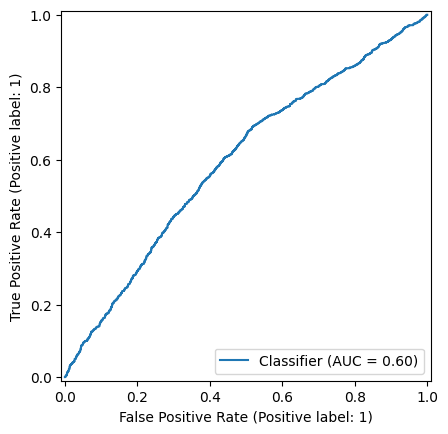

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
RocCurveDisplay.from_predictions(df['label'], 1-df['probability'].map(lambda x: x[0]))